In [1]:
from IPython.display import Image
import os
from scipy import misc
from scipy import ndimage
from scipy.misc import toimage
import scipy.stats as stats
import pandas as pd
import glob
import math
import numpy as np
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import UpSampling2D
from keras.layers import Input
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
K.set_image_dim_ordering('tf')

from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import RMSprop
from keras.models import load_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge

from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = preprocessing.MinMaxScaler()

def parse_filename(long_name):
    part = long_name.split('.')
    part = part[1].split('_')
    return part[0]


def load_images_by_filename(pic_list):
    houses = dict()
    for filename in pic_list:
        img = misc.imread(filename)
        if img is not None:
            houses[parse_filename(filename)]=np.array(img)
            #images.append(np.array(img))
    #return images
    return houses

def rmse(predictions,targets):
    return np.sqrt(((predictions - targets)**2).mean())

def percentwithin10(predictions,targets):
    count = 0;
    for i in range(0,len(targets)):
        if math.fabs(predictions.iloc[i] - targets[i]) < 0.10 * targets[i]:
            count+=1;
    return count / len(targets);

def percentwithin10_1(predictions,targets):
    count = 0;
    for i in range(0,len(targets)):
        if math.fabs(predictions[i] - targets[i]) < 0.10 * targets[i]:
            count+=1
    print ('total count ' + str(count)+ ' out of ' + str(len(targets)))
    return count / len(targets);

def load_images_to_map(pic_list):
    houses = dict()
    for filename in pic_list:
        img = misc.imread(filename)
        if img is not None:
            houses[parse_filename(filename)]=np.array(img)
            #images.append(np.array(img))
    return houses

def get_median_error(pred, truth):
    vals = []
    for i in range(0,len(pred)):
        err = math.fabs(pred[i] - truth[i])
        percent = err / truth[i]
        vals.append(percent)
    return np.median(vals)
    

Using TensorFlow backend.
D:\Anaconda3_10\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
D:\Anaconda3_10\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
def load_dataframe():
    #load the dataframe

    # read in data about houses...clean data, normalize, and bring in zip code medians
    path = "D:/thesis/*.csv"
    allFiles = glob.glob(path)
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    frame = pd.concat(list_)

    frame.columns = ['SALE', 'DATE', 'PROP_TYPE', 'ADDRESS', 'CITY', 'STATE',
           'ZIP', 'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SQ_FEET', 'LOT_SIZE',
           'YEAR_BUILT', 'DAYS_ON_MARKET', 'DL_SQFT', 'HOA', 'STATUS',
           'TIME1', 'TIME2',
           'URL',
           'SOURCE', 'MLS', 'FAVORITE', 'INTERESTED', 'LATITUDE', 'LONGITUDE']

    df2 = frame[['DATE','DAYS_ON_MARKET','DL_SQFT','MLS','ZIP','CITY','PRICE','BEDS','BATHS','SQ_FEET','LOT_SIZE','YEAR_BUILT',
                'HOA','LATITUDE','LONGITUDE']]


    df2 = df2.drop_duplicates() 
    df2 = df2[np.isfinite(df2['PRICE'])]
    df2 = df2[np.isfinite(df2['BEDS'])]
    df2 = df2[np.isfinite(df2['BATHS'])]
    df2 = df2[np.isfinite(df2['YEAR_BUILT'])]
    df2 = df2[np.isfinite(df2['MLS'])]
    df2['HOA'] = df2['HOA'].fillna(0)

    logAge = np.log(2019 - df2.YEAR_BUILT)
    df2['logAge'] = logAge

    def categor(x):
        if x < 8276:
            return 0
        elif x < 11717:
            return 1
        elif x < 17424:
            return 2
        else:
            return 3

    df2['LOT_SIZE'] = df2['LOT_SIZE'].fillna(df2['LOT_SIZE'].median())
    df2['LOT_SIZE'] = df2.LOT_SIZE.apply(categor)

    df2.loc[df2.ZIP == 46001,'ZIP'] = 46168
    df2.loc[df2.ZIP == 46067,'ZIP'] = 46077
    df2.loc[df2.CITY == 'Noblesville','ZIP'] = 46062

    df_medians = pd.read_csv("D:/thesis/medians/Book3.csv", index_col = None, header = None, names = ['ZIP','b','c','d', 'MEDIAN'])
    del df_medians['b']
    del df_medians['c']
    del df_medians['d']

    df4 = pd.merge(df2, df_medians, on='ZIP', how='left')

    df4 = df4.dropna()
    df4.MLS = df4.MLS.astype('int32')
    df4.MLS = df4.MLS.astype(str)

    #remove price outliers
    df4 = df4[df4.PRICE <= 800000]
    df4 = df4[df4.PRICE >= 120000]
    # fix this single zip error ~!!!!!!!!!!!!!!CHECK THIS 
    #df4.MEDIAN[df4.ZIP == 46203] = 60200  
    
    return df4


def load_image_map():
    picfiles = glob.glob('d:/house_images_2/**/*.jpg', recursive=True)
    h = load_images_to_map(picfiles)
    return h

def create_image_split(df, h):   # takes dataframe and image map
    # 
    #   create lists for pics, MLS, and price
    #   order is maintained
    pics = []
    nums = []
    prices = []
    df4 = df
    for key in list(h):
        val = df4.where(df4.MLS == key).dropna() 
        if val.size != 0 and math.isinf(val.PRICE.item()) == False:
            resized = misc.imresize(h[key], (224, 224)).astype('float32')
   #         resized = misc.imresize(h[key], (128, 192)).astype('float32')
            prices.append(val.PRICE.astype('float32').item())
            pics.append(resized)
            nums.append(key)

    # save them as numpy arrays

    nums = np.array(nums)
    pics = np.array(pics)
    prices = np.array(prices)
    
    return nums, pics, prices

In [4]:
from sklearn.cross_validation import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
kf = KFold(n_splits= 10, shuffle = True)

In [36]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

In [5]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50

In [5]:
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input

In [5]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

In [53]:
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

In [14]:
house_data = load_dataframe()
features= ['MLS','PRICE','BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS_ON_MARKET',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN']
house_data = house_data.dropna()
X = house_data[features]
y = house_data.PRICE

(5926, 17)
(5853, 17)
(5418, 17)


In [7]:
image_map = load_image_map()
nums, pics, prices = create_image_split(X, image_map)

D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:111: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [43]:
autoencoder = load_model('autoencoder.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
encoder = ResNet50(include_top = False, weights='imagenet', input_shape = (224, 224, 3))

In [37]:
encoder = VGG16(weights='imagenet', include_top=False, input_shape = (200, 300, 3))

In [8]:
encoder = Xception(weights='imagenet', include_top=False, input_shape = (200, 300, 3))

In [8]:
encoder = InceptionV3(weights='imagenet', include_top=False, input_shape = (200, 300, 3))

In [55]:
encoder = InceptionResNetV2(weights='imagenet', include_top=False, input_shape = (200, 300, 3))

In [9]:
#populate features into map from resnet

img_pred_map = { }
pro_pics = preprocess_input(pics)
#pro_pics = pics / 255
features = encoder.predict(pro_pics)
#features = encoder.predict(pics)
#features = np.reshape(features,(5408,12288))
for i in range(len(pro_pics)):
#for i in range(len(pics)):
    img_pred_map[nums[i]] = features[i].flatten()

In [10]:
img_pred_map['21528725'].shape

(2048,)

In [11]:
#create data frame of resnet features
image_frame = pd.DataFrame.from_dict(img_pred_map, orient = 'index')

In [12]:
#image_frame = pre_scaled
n_components= 50
pca = PCA(n_components)
#pca = PCA(0.72)
pca_result = pca.fit_transform(image_frame.values)

print ('Cumulative explained variation for principal components: {}'
           .format(np.sum(pca.explained_variance_ratio_)))

Cumulative explained variation for principal components: 0.7122614813732208


In [12]:
n_components = pca_result.shape[1]
print(n_components)

50


In [12]:
#pca = PCA(n_components)

#pca_result_50 = pca_50.fit_transform(merged.values)
#pca_frame = pd.DataFrame(pca.fit_transform(pca_result),
#                         columns=['PCA%i' % i for i in range(n_components)], index=image_frame.index)

pca_frame = pd.DataFrame(pca_result,
                         columns=['PCA%i' % i for i in range(n_components)], index=image_frame.index)

In [15]:
pca_frame.head()

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,...,PCA90,PCA91,PCA92,PCA93,PCA94,PCA95,PCA96,PCA97,PCA98,PCA99
21518867,3.300680,-3.875661,-2.199949,0.170664,-2.906543,-2.256352,1.294361,-4.195972,3.631698,4.150471,...,-0.304144,-0.787118,-0.062526,-0.182725,0.396493,-0.860419,-0.430783,-0.586026,0.436298,0.214589
21520237,0.772930,-2.308974,1.489132,-3.467350,-1.218558,0.468368,-2.269490,-1.970698,-4.017842,-1.833065,...,-0.684856,-0.087182,-0.611577,0.066516,-0.386941,-0.465719,-0.031291,-0.033247,-0.128085,0.146299
21513972,-3.277396,2.540678,0.137023,-1.751553,-3.819296,-7.075798,-1.041396,0.091656,-4.046286,-2.709885,...,0.156288,0.158500,0.172823,-1.187456,-0.555741,-0.195569,-0.268425,-0.604040,0.243740,0.670848
21539591,-0.685659,8.504430,9.343723,4.641399,2.008321,4.421641,-3.415391,1.881327,2.454999,-2.209731,...,0.401681,-0.524937,-0.968633,0.168176,-0.844559,-0.174764,0.132007,-0.123214,-0.174967,0.769512
21497337,4.657359,-4.261982,2.802040,-5.805594,-0.549825,2.393979,0.704839,-2.939886,2.927243,-1.415295,...,-0.692616,0.356372,-0.617725,-0.060750,-1.075291,0.074072,0.724542,0.842102,0.170803,0.447663


In [13]:
merged = X.merge(pca_frame, left_on = 'MLS', right_index = True, how = 'inner' )

In [ ]:
ran this one below

In [14]:
data_features = ['DAYS_ON_MARKET','BEDS','BATHS','SQ_FEET','LOT_SIZE','YEAR_BUILT',
                'HOA','LATITUDE','LONGITUDE','logAge','MEDIAN']

cols = [col for col in merged.columns if col not in data_features]
cols = ['PCA0','PCA1','PCA2','PCA3']
cols = ['PCA0','PCA1','PCA3']

In [15]:
df3 = merged[['DAYS_ON_MARKET','BEDS','BATHS','SQ_FEET','LOT_SIZE','YEAR_BUILT',
                'HOA','LATITUDE','LONGITUDE','logAge','MEDIAN']]


In [26]:
df4 = merged[['DAYS_ON_MARKET','BEDS','BATHS','SQ_FEET','LOT_SIZE','YEAR_BUILT',
                'HOA','LATITUDE','LONGITUDE','logAge','MEDIAN']]

In [27]:
df4.head()

,DAYS_ON_MARKET,BEDS,BATHS,SQ_FEET,LOT_SIZE,YEAR_BUILT,HOA,LATITUDE,LONGITUDE,logAge,MEDIAN
1,139.0,4.0,2.5,3923.0,16117.0,1990.0,29.0,39.972871,-86.165201,3.367296,317906.0
3,127.0,4.0,4.0,5124.0,18295.0,1996.0,50.0,39.936647,-86.228057,3.135494,317906.0
4,125.0,5.0,5.0,7732.0,26136.0,2000.0,50.0,39.938926,-86.219860,2.944439,317906.0
5,135.0,3.0,3.5,5462.0,69696.0,1983.0,19.0,39.932524,-86.171818,3.583519,317906.0
6,125.0,4.0,2.5,2016.0,23400.0,1969.0,0.0,39.937711,-86.117675,3.912023,317906.0


In [16]:
#remove extras, set truth values

df2 = merged.loc[:, merged.columns != 'MLS']
y = merged.PRICE
df2 = df2.loc[:, df2.columns != 'PRICE']

In [56]:
split=0.2

train_X,valid_X,train_ground,valid_ground = train_test_split(df2,
                                                             y, 
                                                             test_size=split 
                                                             )
print(train_X.shape, valid_X.shape)

(4379, 61) (1095, 61)


In [57]:
scaler = MinMaxScaler()
transformer = min_max_scaler.fit(train_X)
train_X = pd.DataFrame(transformer.transform(train_X), index=train_X.index, columns=train_X.columns)
valid_X = pd.DataFrame(transformer.transform(valid_X), index=valid_X.index, columns=valid_X.columns)

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [39]:
n_estimators = [ 500, 1000]
max_features = ['auto']
max_depth = [ 20]
min_samples_split = [ 2]
min_samples_leaf = [ 2 ]
bootstrap = [True]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [40]:
rf = RandomForestRegressor()
rf_random = GridSearchCV(rf, 
                               random_grid, 
                               cv = 3, 
                               verbose=1,  n_jobs = -1)

In [41]:
rf_random.fit(df3, y)
print(rf_random.best_params_)
best = rf_random.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   31.9s finished


{'max_features': 'auto', 'min_samples_leaf': 2, 'bootstrap': True, 'min_samples_split': 2, 'n_estimators': 1000, 'max_depth': 20}


In [19]:
gb_grid_params = {'learning_rate': [0.01],
              'max_depth': [ 8],
              'min_samples_leaf': [30],
              'max_features': [ 0.3,0.5 ],
              'n_estimators' : [ 1000] 
              }

rf = GradientBoostingRegressor(loss = 'ls')
rf_random = GridSearchCV(rf, 
                               gb_grid_params, 
                               cv = 6, 
                               verbose=1, n_jobs = -1)

In [1]:
df3.head()

NameError: name 'df3' is not defined

In [20]:
rf_random.fit(df3, y)
print(rf_random.best_params_)
best_with = rf_random.best_estimator_

Fitting 6 folds for each of 2 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   11.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   11.7s finished


{'max_depth': 8, 'n_estimators': 1000, 'max_features': 0.3, 'learning_rate': 0.01, 'min_samples_leaf': 30}


In [22]:
# save this model
import pickle

pickle.dump(best_with, open("gbr.p","wb"))


In [35]:
rf_random.fit(df4, y)
print(rf_random.best_params_)
best_without = rf_random.best_estimator_

Fitting 6 folds for each of 2 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   11.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   11.6s finished


{'learning_rate': 0.01, 'n_estimators': 1000, 'max_features': 0.3, 'min_samples_leaf': 30, 'max_depth': 8}


In [29]:

#cross validation of models
#X = df2[data_features]
X = df3

sum_acc = 0
sum_r2 = 0
sum_mae = 0
sum_mer = 0
for train_index, test_index in kf.split(X):
    
    #get splits of pandas dataframes
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    transformer = min_max_scaler.fit(X_train)
    X_train = pd.DataFrame(transformer.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(transformer.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    #change to numpy arrays - watch the -ed for non NN
    X_trained = X_train.values
    X_tested = X_test.values
    y_trained = y_train.values
    y_tested = y_test.values
    
    #rf = GradientBoostingRegressor(n_estimators= 3000, max_depth= 4,
    #                               min_samples_leaf= 50, learning_rate= 0.01, max_features= 0.3 )
    #rf.fit (X_train,y_train )
    
    #rf = RandomForestRegressor(n_estimators= 1000)
    #rf.fit(X_train, y_train )
    
    #rf = Ridge(alpha=2)
    #rf.fit(X_train, y_train ) 
    
    #rf = linear_model.LinearRegression()
    #rf.fit (X_train,y_train )
    
    #rf = build_model()
    #rf.fit(X_trained, y_trained, epochs=1000, verbose = 1)
    
    rf = best
    rf.fit( X_train, y_train )
    
  
    preds = rf.predict(X_test)
    y_test = y.values

    
    mer = get_median_error(preds, y_tested)
    r2 = r2_score(y_tested, preds)
    mae = mean_absolute_error(y_tested, preds)
    perc10 = percentwithin10_1(y_tested, preds)
    
    print("accuracy validation: " + str(perc10))
    print("median error: " + str(mer))
    
    sum_acc += perc10
    sum_r2 += r2
    sum_mae += mae
    sum_mer += mer
    
    print('------------------')

print("average acc: " + str(sum_acc/10))
print("average mer: " + str(sum_mer/10))
    

total count 315 out of 499
accuracy validation: 0.6312625250501002
median error: 0.07146860161321826
------------------
total count 321 out of 499
accuracy validation: 0.6432865731462926
median error: 0.06682064998140788
------------------
total count 332 out of 499
accuracy validation: 0.6653306613226453
median error: 0.06790146825653078
------------------
total count 312 out of 499
accuracy validation: 0.625250501002004
median error: 0.07274562979865883
------------------
total count 307 out of 499
accuracy validation: 0.6152304609218436
median error: 0.0746629595524392
------------------
total count 301 out of 499
accuracy validation: 0.6032064128256514
median error: 0.07803874921737325
------------------
total count 322 out of 499
accuracy validation: 0.6452905811623246
median error: 0.06939257558975906
------------------
total count 311 out of 499
accuracy validation: 0.6232464929859719
median error: 0.07518095948213255
------------------
total count 313 out of 499
accuracy valida

In [34]:
from mlxtend.evaluate import paired_ttest_5x2cv

In [42]:
t, p = paired_ttest_5x2cv(estimator1=best,
                          estimator2=best_with,
                          X=df3, y=y,
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -3.316
p value: 0.021


In [239]:
#mergin auotencoder / features pipeline

def build_model():
    branch1 = Sequential()
    branch1.add(Dense(128, activation = 'relu', input_shape=(15,)))
    branch1.add(Dropout(0.70))
    #branch1.add(Dense(256,activation = 'relu'))
    #branch1.add(Dropout(0.50))
    #branch1.add(Dense(1024,activation = 'relu'))
    #branch1.add(Dropout(0.8))
    branch1.add(Dense(128,activation = 'relu'))
    branch1.add(Dropout(0.70))


    

    #print(branch1.summary())
    
    branch2 = Sequential()
    branch2.add(Dense(96, activation = 'relu', input_shape=(11,)))
    branch2.add(Dropout(0.55))
    #branch2.add(BatchNormalization())
    branch2.add(Dense(96, activation = 'relu'))
    branch2.add(Dropout(0.45))
    branch2.add(Dense(64, activation = 'relu'))
    #print(branch2.summary())
    
    model = Sequential()
    model.add(Merge([branch1,branch2], mode = 'concat'))
    model.add(Dense(320, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(1))

    
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    return model

In [53]:
def build_model():
    model = Sequential()
    model.add(Dense(96, activation = 'relu', input_shape=(len(data_features),)))
    model.add(Dropout(0.45))
    model.add(Dense(96, activation = 'relu'))
    model.add(Dropout(0.45))
    model.add(Dense(64, activation = 'relu'))

    model.add(Dense(1))
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    return model

In [48]:
data_features = ['DAYS_ON_MARKET','BEDS','BATHS','SQ_FEET','LOT_SIZE','YEAR_BUILT',
                'HOA','LATITUDE','LONGITUDE','logAge','MEDIAN']

cols = [col for col in df2.columns if col not in data_features]

In [50]:
split=0.2

train_X,valid_X,train_ground,valid_ground = train_test_split(df3,
                                                             y, 
                                                             test_size=split 
                                                             )
print(train_X.shape, valid_X.shape)

(3992, 11) (998, 11)


In [51]:
transformer = min_max_scaler.fit(train_X)
train_X = pd.DataFrame(transformer.transform(train_X), index=train_X.index, columns=train_X.columns)
valid_X = pd.DataFrame(transformer.transform(valid_X), index=valid_X.index, columns=valid_X.columns)

In [74]:
epochs = 1000

X1 = train_X[data_features].values

print(X1.shape)

valid_X1 = valid_X[data_features].values

rf = build_model()
print(rf.summary())
model_trained = rf.fit(X1, train_ground, epochs=epochs, verbose = 1,
                       validation_data=(valid_X1, valid_ground))

(3992, 11)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 96)                1152      
_________________________________________________________________
dropout_11 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 96)                9312      
_________________________________________________________________
dropout_12 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                6208      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 16,737
Trainable params: 16,737
Non-trainable params: 0
_____________________________________________________________

3992/3992 [==============================] - 0s - loss: 4226882224.4810 - mean_absolute_error: 46042.4026 - val_loss: 3433147995.3186 - val_mean_absolute_error: 35549.7984
Epoch 83/1000
3992/3992 [==============================] - 0s - loss: 4067744602.8056 - mean_absolute_error: 45097.3145 - val_loss: 3421416493.1463 - val_mean_absolute_error: 35641.6548
Epoch 84/1000
3992/3992 [==============================] - 0s - loss: 4061936221.3707 - mean_absolute_error: 45528.2965 - val_loss: 3448926614.3166 - val_mean_absolute_error: 35500.2231
Epoch 85/1000
3992/3992 [==============================] - 0s - loss: 4080289959.2465 - mean_absolute_error: 44748.8802 - val_loss: 3459864093.7555 - val_mean_absolute_error: 35516.4690
Epoch 86/1000
3992/3992 [==============================] - 0s - loss: 3954528653.0822 - mean_absolute_error: 44572.1781 - val_loss: 3427016706.0521 - val_mean_absolute_error: 35464.3352
Epoch 87/1000
3992/3992 [==============================] - 0s - loss: 4061908071.631

3992/3992 [==============================] - 0s - loss: 4068349752.9459 - mean_absolute_error: 44197.6885 - val_loss: 3369576074.5170 - val_mean_absolute_error: 34620.5426
Epoch 169/1000
3992/3992 [==============================] - 0s - loss: 3824138148.1683 - mean_absolute_error: 43534.6558 - val_loss: 3354571977.1062 - val_mean_absolute_error: 34702.2372
Epoch 170/1000
3992/3992 [==============================] - 0s - loss: 4004430312.9138 - mean_absolute_error: 44621.5859 - val_loss: 3356553378.1162 - val_mean_absolute_error: 34627.5624
Epoch 171/1000
3992/3992 [==============================] - 0s - loss: 3903036782.3006 - mean_absolute_error: 43901.9476 - val_loss: 3360949449.1062 - val_mean_absolute_error: 34614.5498
Epoch 172/1000
3992/3992 [==============================] - 0s - loss: 4098761798.2846 - mean_absolute_error: 44813.4280 - val_loss: 3405930046.5892 - val_mean_absolute_error: 34754.2709
Epoch 173/1000
3992/3992 [==============================] - 0s - loss: 368123263

3992/3992 [==============================] - 0s - loss: 3911771561.2986 - mean_absolute_error: 43135.2932 - val_loss: 3398535545.5872 - val_mean_absolute_error: 34590.0122
Epoch 255/1000
3992/3992 [==============================] - 0s - loss: 3856698587.0621 - mean_absolute_error: 43223.9139 - val_loss: 3343829002.2605 - val_mean_absolute_error: 34528.7893
Epoch 256/1000
3992/3992 [==============================] - 0s - loss: 3938076257.7315 - mean_absolute_error: 43677.9680 - val_loss: 3357352664.4970 - val_mean_absolute_error: 34453.2655
Epoch 257/1000
3992/3992 [==============================] - 0s - loss: 3844605537.4749 - mean_absolute_error: 43355.7351 - val_loss: 3371425876.1363 - val_mean_absolute_error: 34442.6402
Epoch 258/1000
3992/3992 [==============================] - 0s - loss: 3995410488.4329 - mean_absolute_error: 43896.8375 - val_loss: 3369144853.5471 - val_mean_absolute_error: 34448.9285
Epoch 259/1000
3992/3992 [==============================] - 0s - loss: 388710861

3992/3992 [==============================] - 0s - loss: 3743715618.8858 - mean_absolute_error: 42766.0594 - val_loss: 3328499256.4329 - val_mean_absolute_error: 34512.6673
Epoch 341/1000
3992/3992 [==============================] - 0s - loss: 3679525873.6353 - mean_absolute_error: 42682.1167 - val_loss: 3333071071.6794 - val_mean_absolute_error: 34355.9179
Epoch 342/1000
3992/3992 [==============================] - 0s - loss: 3762186238.2044 - mean_absolute_error: 42589.2671 - val_loss: 3321715773.5631 - val_mean_absolute_error: 34402.6956
Epoch 343/1000
3992/3992 [==============================] - 0s - loss: 3727976555.7355 - mean_absolute_error: 42961.5004 - val_loss: 3320561079.1503 - val_mean_absolute_error: 34492.4719
Epoch 344/1000
3992/3992 [==============================] - 0s - loss: 3836905742.8778 - mean_absolute_error: 42999.2499 - val_loss: 3319812725.9960 - val_mean_absolute_error: 34408.3607
Epoch 345/1000
3992/3992 [==============================] - 0s - loss: 382586306

3992/3992 [==============================] - 0s - loss: 3773593519.9679 - mean_absolute_error: 42468.4046 - val_loss: 3330656110.3006 - val_mean_absolute_error: 34346.5425
Epoch 427/1000
3992/3992 [==============================] - 0s - loss: 3774505130.3246 - mean_absolute_error: 42675.7199 - val_loss: 3333816418.5010 - val_mean_absolute_error: 34314.0017
Epoch 428/1000
3992/3992 [==============================] - 0s - loss: 3723142168.6253 - mean_absolute_error: 42292.2498 - val_loss: 3348687305.6192 - val_mean_absolute_error: 34357.8110
Epoch 429/1000
3992/3992 [==============================] - 0s - loss: 3811883150.6212 - mean_absolute_error: 42094.7677 - val_loss: 3404522426.2285 - val_mean_absolute_error: 34691.1739
Epoch 430/1000
3992/3992 [==============================] - 0s - loss: 3713141549.6593 - mean_absolute_error: 42496.2023 - val_loss: 3324169991.6954 - val_mean_absolute_error: 34511.8141
Epoch 431/1000
3992/3992 [==============================] - 0s - loss: 388639709

3992/3992 [==============================] - 0s - loss: 3627882448.8016 - mean_absolute_error: 40879.5516 - val_loss: 3306648565.7395 - val_mean_absolute_error: 33830.1091
Epoch 513/1000
3992/3992 [==============================] - 0s - loss: 3591119587.7836 - mean_absolute_error: 41286.7080 - val_loss: 3316289154.3086 - val_mean_absolute_error: 33814.4458
Epoch 514/1000
3992/3992 [==============================] - 0s - loss: 3633376657.6994 - mean_absolute_error: 41544.3545 - val_loss: 3347779503.9679 - val_mean_absolute_error: 34631.4703
Epoch 515/1000
3992/3992 [==============================] - 0s - loss: 3484455767.2144 - mean_absolute_error: 40042.8615 - val_loss: 3313330756.7455 - val_mean_absolute_error: 33784.5860
Epoch 516/1000
3992/3992 [==============================] - 0s - loss: 3450279083.6072 - mean_absolute_error: 40152.1818 - val_loss: 3337769331.4309 - val_mean_absolute_error: 33898.6680
Epoch 517/1000
3992/3992 [==============================] - 0s - loss: 362074240

3992/3992 [==============================] - 0s - loss: 3555425223.5671 - mean_absolute_error: 39919.8987 - val_loss: 3298138040.1764 - val_mean_absolute_error: 33525.6216
Epoch 599/1000
3992/3992 [==============================] - 0s - loss: 3470444673.7956 - mean_absolute_error: 40458.6348 - val_loss: 3309649070.4289 - val_mean_absolute_error: 33496.0153
Epoch 600/1000
3992/3992 [==============================] - 0s - loss: 3359154674.6613 - mean_absolute_error: 39733.2618 - val_loss: 3300271163.5110 - val_mean_absolute_error: 33486.5631
Epoch 601/1000
3992/3992 [==============================] - 0s - loss: 3392217100.3126 - mean_absolute_error: 39765.8150 - val_loss: 3305837173.9960 - val_mean_absolute_error: 33489.3153
Epoch 602/1000
3992/3992 [==============================] - 0s - loss: 3369904144.9299 - mean_absolute_error: 39717.4187 - val_loss: 3310438871.9840 - val_mean_absolute_error: 33488.9897
Epoch 603/1000
3992/3992 [==============================] - 0s - loss: 332079888

3992/3992 [==============================] - 0s - loss: 3472897906.9178 - mean_absolute_error: 39998.2528 - val_loss: 3273929040.5451 - val_mean_absolute_error: 33744.3066
Epoch 685/1000
3992/3992 [==============================] - 0s - loss: 3527330651.8317 - mean_absolute_error: 40004.8960 - val_loss: 3273753913.9719 - val_mean_absolute_error: 33754.7933
Epoch 686/1000
3992/3992 [==============================] - 0s - loss: 3543015030.5090 - mean_absolute_error: 40093.5301 - val_loss: 3273444838.3487 - val_mean_absolute_error: 33759.4053
Epoch 687/1000
3992/3992 [==============================] - 0s - loss: 3351009821.2425 - mean_absolute_error: 40150.5607 - val_loss: 3282358194.0200 - val_mean_absolute_error: 33739.1720
Epoch 688/1000
3992/3992 [==============================] - 0s - loss: 3453901775.7756 - mean_absolute_error: 40192.1520 - val_loss: 3268898524.6012 - val_mean_absolute_error: 33774.5966
Epoch 689/1000
3992/3992 [==============================] - 0s - loss: 336315436

3992/3992 [==============================] - 0s - loss: 3413429427.0461 - mean_absolute_error: 39727.6279 - val_loss: 3269961087.7435 - val_mean_absolute_error: 33765.5890
Epoch 771/1000
3992/3992 [==============================] - 0s - loss: 3402788966.6052 - mean_absolute_error: 39789.4357 - val_loss: 3321209443.5271 - val_mean_absolute_error: 33999.1784
Epoch 772/1000
3992/3992 [==============================] - 0s - loss: 3382311508.6493 - mean_absolute_error: 39743.3967 - val_loss: 3280357577.1062 - val_mean_absolute_error: 34048.1527
Epoch 773/1000
3992/3992 [==============================] - 0s - loss: 3323002823.5671 - mean_absolute_error: 39648.2140 - val_loss: 3270186579.1102 - val_mean_absolute_error: 33791.6878
Epoch 774/1000
3992/3992 [==============================] - 0s - loss: 3339413782.8297 - mean_absolute_error: 39421.2452 - val_loss: 3275479981.9158 - val_mean_absolute_error: 33945.0404
Epoch 775/1000
3992/3992 [==============================] - 0s - loss: 330944273

3992/3992 [==============================] - 0s - loss: 3403599336.4008 - mean_absolute_error: 39593.4384 - val_loss: 3246489335.2786 - val_mean_absolute_error: 33773.3106
Epoch 857/1000
3992/3992 [==============================] - 0s - loss: 3461794750.8457 - mean_absolute_error: 40430.4054 - val_loss: 3245274029.9158 - val_mean_absolute_error: 33855.3191
Epoch 858/1000
3992/3992 [==============================] - 0s - loss: 3317391060.6493 - mean_absolute_error: 39908.1288 - val_loss: 3261318854.0281 - val_mean_absolute_error: 33803.0497
Epoch 859/1000
3992/3992 [==============================] - 0s - loss: 3403230409.6192 - mean_absolute_error: 39899.7759 - val_loss: 3246093547.9920 - val_mean_absolute_error: 34030.6786
Epoch 860/1000
3992/3992 [==============================] - 0s - loss: 3308681309.8838 - mean_absolute_error: 39883.8790 - val_loss: 3270523232.9619 - val_mean_absolute_error: 33815.4713
Epoch 861/1000
3992/3992 [==============================] - 0s - loss: 339650689

3992/3992 [==============================] - 0s - loss: 3386636289.7956 - mean_absolute_error: 39660.5921 - val_loss: 3263326341.3868 - val_mean_absolute_error: 33958.9926
Epoch 943/1000
3992/3992 [==============================] - 0s - loss: 3166130263.7275 - mean_absolute_error: 38772.1416 - val_loss: 3276383320.2405 - val_mean_absolute_error: 33771.9579
Epoch 944/1000
3992/3992 [==============================] - 0s - loss: 3422845347.3988 - mean_absolute_error: 39635.1326 - val_loss: 3283966754.3727 - val_mean_absolute_error: 33821.7723
Epoch 945/1000
3992/3992 [==============================] - 0s - loss: 3322630812.9860 - mean_absolute_error: 39487.3454 - val_loss: 3261913572.2966 - val_mean_absolute_error: 33962.1791
Epoch 946/1000
3992/3992 [==============================] - 0s - loss: 3376800167.5030 - mean_absolute_error: 39210.6654 - val_loss: 3259984309.0982 - val_mean_absolute_error: 33809.0324
Epoch 947/1000
3992/3992 [==============================] - 0s - loss: 345868588

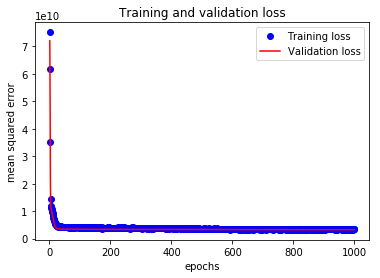

In [75]:
loss = model_trained.history['loss']
val_loss = model_trained.history['val_loss']
epoch = range(epochs)
plt.figure()
plt.plot(epoch[1:], loss[1:], 'bo', label='Training loss')
#plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch[1:], val_loss[1:], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('mean squared error')
plt.legend()
plt.show()

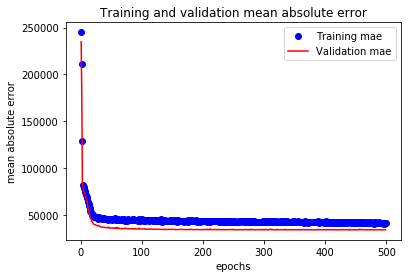

In [67]:
loss = model_trained.history['mean_absolute_error']
val_loss = model_trained.history['val_mean_absolute_error']
epoch = range(epochs)
plt.figure()
plt.plot(epoch[1:], loss[1:], 'bo', label='Training mae')
#plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch[1:], val_loss[1:], 'r', label='Validation mae')
plt.title('Training and validation mean absolute error')
plt.xlabel('epochs')
plt.ylabel('mean absolute error')
plt.legend()
plt.show()

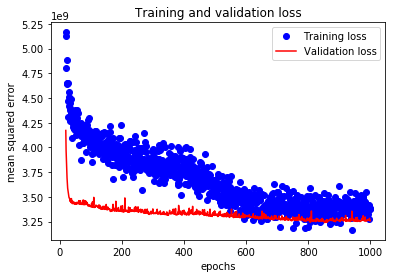

In [78]:
loss = model_trained.history['loss']
val_loss = model_trained.history['val_loss']
epoch = range(epochs)
plt.figure()
plt.plot(epoch[20:], loss[20:], 'bo', label='Training loss')
#plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch[20:], val_loss[20:], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('mean squared error')
plt.legend()
plt.show()

In [77]:
#testing data

preds = rf.predict(valid_X1)
mer = get_median_error(preds, valid_ground.values)
acc = percentwithin10_1(valid_ground.values, preds)
print("acc: " + str(acc))
print("mer: " + str(mer))

total count 496 out of 998
acc: 0.4969939879759519
mer: 0.09835218675312572


In [247]:
epochs = 200

X1 = train_X[data_features].values
X2 = train_X[cols].values
print(X1.shape)
print(X2.shape)
valid_X1 = valid_X[data_features].values
valid_X2 = valid_X[cols].values
rf = build_model()
print(rf.summary())
model_trained = rf.fit([X2,X1], train_ground, epochs=epochs, verbose = 1,
                       validation_data=([valid_X2,valid_X1], valid_ground))

(3992, 11)
(3992, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_29 (Merge)             (None, 192)               0         
_________________________________________________________________
dense_225 (Dense)            (None, 320)               61760     
_________________________________________________________________
dropout_156 (Dropout)        (None, 320)               0         
_________________________________________________________________
dense_226 (Dense)            (None, 64)                20544     
_________________________________________________________________
dense_227 (Dense)            (None, 1)                 65        
Total params: 117,601
Trainable params: 117,601
Non-trainable params: 0
_________________________________________________________________
None


D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:29: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


ValueError: Error when checking input: expected dense_220_input to have shape (None, 15) but got array with shape (3992, 4)

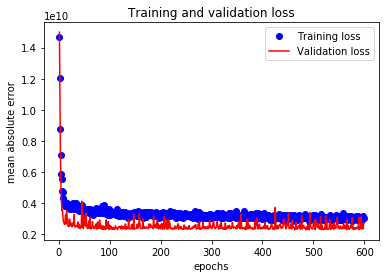

In [180]:
loss = model_trained.history['loss']
val_loss = model_trained.history['val_loss']
epoch = range(epochs)
plt.figure()
plt.plot(epoch[1:], loss[1:], 'bo', label='Training loss')
#plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch[1:], val_loss[1:], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('mean absolute error')
plt.legend()
plt.show()

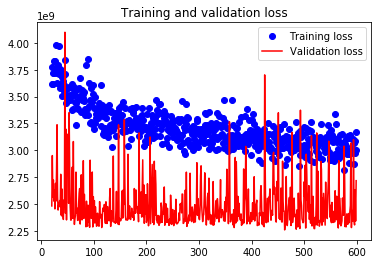

In [181]:
loss = model_trained.history['loss']
val_loss = model_trained.history['val_loss']
epoch = range(epochs)
plt.figure()
plt.plot(epoch[20:], loss[20:], 'bo', label='Training loss')
#plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch[20:], val_loss[20:], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [182]:
#traing data

preds = rf.predict([X2,X1])
mer = get_median_error(preds, train_ground.values)
acc = percentwithin10_1(train_ground.values, preds)
print("acc: " + str(acc))
print("mer: " + str(mer))

total count 2196 out of 3992
acc: 0.5501002004008017
mer: 0.08652428446691177


In [183]:
#testing data

preds = rf.predict([valid_X2,valid_X1])
mer = get_median_error(preds, valid_ground.values)
acc = percentwithin10_1(valid_ground.values, preds)
print("acc: " + str(acc))
print("mer: " + str(mer))

total count 550 out of 998
acc: 0.5511022044088176
mer: 0.08670078505057713


In [186]:
train_X[cols].head()

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,...,PCA90,PCA91,PCA92,PCA93,PCA94,PCA95,PCA96,PCA97,PCA98,PCA99
845,0.654271,0.650530,0.321646,0.500510,0.529183,0.216787,0.649408,0.442242,0.483579,0.550306,...,0.349233,0.445477,0.323632,0.406999,0.352316,0.599060,0.363822,0.477286,0.330541,0.288030
2203,0.401118,0.649597,0.593982,0.608443,0.479537,0.403128,0.409366,0.628908,0.410993,0.376788,...,0.178104,0.337203,0.599530,0.579667,0.322045,0.418101,0.274736,0.446623,0.143849,0.237893
5943,0.082486,0.408099,0.384120,0.431977,0.407521,0.652255,0.682533,0.502669,0.436113,0.480176,...,0.233668,0.445207,0.557802,0.475915,0.350418,0.491893,0.194217,0.537307,0.257094,0.381622
5979,0.273540,0.266638,0.409607,0.307183,0.483160,0.504953,0.452345,0.490183,0.519542,0.532638,...,0.276862,0.525768,0.423833,0.518231,0.121783,0.402061,0.419017,0.607196,0.320678,0.359753
2803,0.777982,0.437343,0.413819,0.691762,0.372383,0.547864,0.654385,0.497016,0.508651,0.569097,...,0.421329,0.519381,0.500563,0.590053,0.212438,0.412285,0.399909,0.501297,0.314524,0.397636


[Text(0,0.5,'PRICE'), Text(0.5,0,'PCA0')]

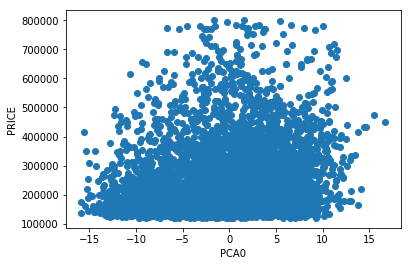

In [266]:
fig, ax = plt.subplots()
ax.scatter(x=df3.PCA0, y = y)
ax.set( xlabel='PCA0', ylabel='PRICE')

[Text(0,0.5,'PRICE'), Text(0.5,0,'PCA1')]

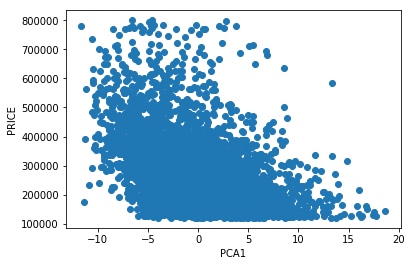

In [267]:
fig, ax = plt.subplots()
ax.scatter(x=df3.PCA1, y = y)
ax.set( xlabel='PCA1', ylabel='PRICE')

[Text(0,0.5,'PRICE'), Text(0.5,0,'PCA2')]

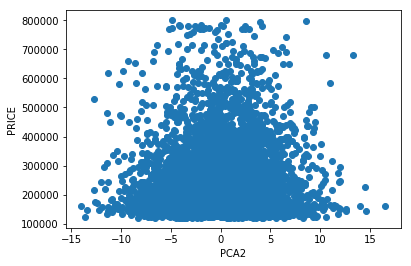

In [268]:
fig, ax = plt.subplots()
ax.scatter(x=df3.PCA2, y = y)
ax.set( xlabel='PCA2', ylabel='PRICE')

[Text(0,0.5,'PRICE'), Text(0.5,0,'PCA3')]

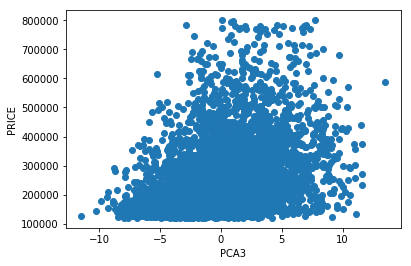

In [269]:
fig, ax = plt.subplots()
ax.scatter(x=df3.PCA3, y = y)
ax.set( xlabel='PCA3', ylabel='PRICE')

In [264]:
plt.scatter(x=train_X.PCA20, y = train_ground)

AttributeError: 'DataFrame' object has no attribute 'PCA20'

In [ ]:
epochs = 510

X1 = train_X[data_features].values
X2 = train_X[cols].values
print(X1.shape)
print(X2.shape)
valid_X1 = valid_X[data_features].values
valid_X2 = valid_X[cols].values
rf = build_model()
print(rf.summary())
model_trained = rf.fit([X2,X1], train_ground, epochs=epochs, verbose = 1,
                       validation_data=([valid_X2,valid_X1], valid_ground))

In [41]:
data_features = ['DAYS_ON_MARKET','BEDS','BATHS','SQ_FEET','LOT_SIZE','YEAR_BUILT',
                'HOA','LATITUDE','LONGITUDE','logAge','MEDIAN']

cols = [col for col in df2.columns if col not in data_features]

In [112]:
#cross validation of models
#X = df2[data_features]
X = df2
epochs = 200
sum_acc = 0
sum_r2 = 0
sum_mae = 0
sum_mer = 0
for train_index, test_index in kf.split(X):
    
    #get splits of pandas dataframes
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    transformer = min_max_scaler.fit(X_train)
    X_train = pd.DataFrame(transformer.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(transformer.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    #change to numpy arrays - watch the -ed for non NN
    X_trained = X_train.values
    X_tested = X_test.values
    y_trained = y_train.values
    y_tested = y_test.values
    

    X1 = X_train[data_features].values
    X2 = X_train[cols].values
    valid_X1 = X_test[data_features].values
    valid_X2 = X_test[cols].values
    
    rf = build_model()
    #rf.fit(X_trained, y_trained, epochs=500, verbose = 1)
    rf.fit([X2,X1], y_train, epochs=epochs, verbose = 0,
                       validation_data=([valid_X2,valid_X1], y_test))
    #rf = best
    #rf.fit( X_train, y_train )
    
  
    #preds = rf.predict(X_test)
    preds = rf.predict([valid_X2,valid_X1])
    y_test = y.values

    
    mer = get_median_error(preds, y_tested)
    r2 = r2_score(y_tested, preds)
    mae = mean_absolute_error(y_tested, preds)
    perc10 = percentwithin10_1(y_tested, preds)
    
    print("accuracy validation: " + str(perc10))
    print("median error: " + str(mer))
    
    sum_acc += perc10
    sum_r2 += r2
    sum_mae += mae
    sum_mer += mer
    
    print('------------------')

print("average acc: " + str(sum_acc/10))
print("average mer: " + str(sum_mer/10))
    

D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:29: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


total count 246 out of 499
accuracy validation: 0.49298597194388777
median error: 0.09780970149253732
------------------
total count 266 out of 499
accuracy validation: 0.533066132264529
median error: 0.0934829391891892
------------------
total count 259 out of 499
accuracy validation: 0.5190380761523046
median error: 0.09460296713742532
------------------
total count 223 out of 499
accuracy validation: 0.4468937875751503
median error: 0.11175390625
------------------
total count 258 out of 499
accuracy validation: 0.5170340681362725
median error: 0.10290041762672811
------------------
total count 254 out of 499
accuracy validation: 0.5090180360721442
median error: 0.10118732876712329
------------------
total count 235 out of 499
accuracy validation: 0.4709418837675351
median error: 0.1052392578125
------------------
total count 256 out of 499
accuracy validation: 0.5130260521042084
median error: 0.09968887195121952
------------------
total count 232 out of 499
accuracy validation: 0.4